Inital thoughts:
Population estimate table: can fill missing values in 0-4 year olds by taking the sum of 1-4, 5-9, and 10-14 from the estimate of 0-14 - this gives us the number of 0 year olds, which can be added to the 1-4 yos.

Migration table: Can fill missing values in net migration by subtracting emigrants from immigrants. In earlier years the totals aren't calculated, but can be derived from summing the completed ages

Can we look at births/deaths as a weibull distribution modeling time to failure with historic infant mortality rates as an estimate of the rate parameter?

Population (https://data.cso.ie/table/PEA01) and migration (https://data.cso.ie/table/PEA03) datasets were retrieved from data.cso.ie at 10AM on the 6th of October 2023

# Population Estimates Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import itertools
import statsmodels.api as sm

sns.set(style="darkgrid")    

Our first dataset is the population estimates in April from 1950 to 2023.

We first load the dataframe from csv and change the column names to snake_case by converting to lowercase and replacing spaces with underscores, this is done as a stylistic choice so that the column names are in a consistent case with our variable names.

We will apply the same column transformation to multiple csvs throughout the notebook, so we create a function that can be reused later. 

In [2]:
def read_csv_and_fix_names(filename):
    df = pd.read_csv(filename)
    df = df.rename(columns={x: x.lower().replace(' ', '_') for x in df.columns})
    return df

population_df = read_csv_and_fix_names('data/population_estimates_1950_2023.csv')
print(population_df.dtypes)
print(population_df.shape)
population_df.head(15)

statistic_label     object
year                 int64
age_group           object
sex                 object
unit                object
value              float64
dtype: object
(5994, 6)


,statistic_label,year,age_group,sex,unit,value
0,Population Estimates (Persons in April),1950,Under 1 year,Both sexes,Thousand,61.1
1,Population Estimates (Persons in April),1950,Under 1 year,Male,Thousand,31.4
2,Population Estimates (Persons in April),1950,Under 1 year,Female,Thousand,29.7
3,Population Estimates (Persons in April),1950,0 - 4 years,Both sexes,Thousand,NaN
4,Population Estimates (Persons in April),1950,0 - 4 years,Male,Thousand,NaN
5,Population Estimates (Persons in April),1950,0 - 4 years,Female,Thousand,NaN
6,Population Estimates (Persons in April),1950,0 - 14 years,Both sexes,Thousand,851.2
7,Population Estimates (Persons in April),1950,0 - 14 years,Male,Thousand,434.6
8,Population Estimates (Persons in April),1950,0 - 14 years,Female,Thousand,416.6
9,Population Estimates (Persons in April),1950,1 - 4 years,Both sexes,Thousand,249.1


We can see that we have missing values the "value" column, however, this only occurs in the 0-4 years age groups, not every year, and only in years until 1995

In [3]:
population_df.loc[pd.isna(population_df.value)]['age_group'].value_counts()

age_group
0 - 4 years    114
Name: count, dtype: int64

In [4]:
population_df.loc[(population_df['age_group'] == "0 - 4 years") & (pd.isna(population_df['value']))].head()

,statistic_label,year,age_group,sex,unit,value
3,Population Estimates (Persons in April),1950,0 - 4 years,Both sexes,Thousand,NaN
4,Population Estimates (Persons in April),1950,0 - 4 years,Male,Thousand,NaN
5,Population Estimates (Persons in April),1950,0 - 4 years,Female,Thousand,NaN
165,Population Estimates (Persons in April),1952,0 - 4 years,Both sexes,Thousand,NaN
166,Population Estimates (Persons in April),1952,0 - 4 years,Male,Thousand,NaN


In [5]:
population_df.loc[(population_df['age_group']=="0 - 4 years") & (pd.isna(population_df['value']))].tail()

,statistic_label,year,age_group,sex,unit,value
3568,Population Estimates (Persons in April),1994,0 - 4 years,Male,Thousand,NaN
3569,Population Estimates (Persons in April),1994,0 - 4 years,Female,Thousand,NaN
3648,Population Estimates (Persons in April),1995,0 - 4 years,Both sexes,Thousand,NaN
3649,Population Estimates (Persons in April),1995,0 - 4 years,Male,Thousand,NaN
3650,Population Estimates (Persons in April),1995,0 - 4 years,Female,Thousand,NaN


### Missing Data Treatment

We can try to fill in the missing 0-4 year olds using a combination of other columns;
We have "Under 1 year" as a value within age_group, so we should be able to add this to the "1 - 4 years" value to get "0 - 4 years".
We can check if this works by comparing against the completed entries post-1995.

In [6]:
pivoted_population_df = population_df.pivot(columns='age_group', index=['year', 'sex'], values='value')
pivoted_population_df.head()

age_group        0 - 14 years  0 - 4 years  1 - 4 years  10 - 14 years  \
year sex                                                                 
1950 Both sexes         851.2          NaN        249.1          262.1   
     Female             416.6          NaN        121.6          128.7   
     Male               434.6          NaN        127.5          133.4   
1951 Both sexes         854.8        312.9        249.3          260.9   
     Female             418.4        152.6        121.7          128.2   

age_group        15 - 19 years  15 - 24 years  15 years and over  \
year sex                                                           
1950 Both sexes          244.0          452.6             2117.8   
     Female              117.4          217.7             1042.4   
     Male                126.6          234.9             1075.4   
1951 Both sexes          241.2          443.4             2105.8   
     Female              115.4          212.2             1035.6   

age_group        20 - 24 years  25 - 29 years  25 - 44 years  ...  \
year sex                                                      ...   
1950 Both sexes          208.6          201.1          773.6  ...   
     Female              100.3          100.2          380.2  ...   
     Male                108.3          100.9          393.4  ...   
1951 Both sexes          202.2          198.4          771.2  ...   
     Female               96.8           98.8          378.9  ...   

age_group        55 - 59 years  60 - 64 years  65 - 69 years  \
year sex                                                       
1950 Both sexes          130.4          121.9          109.3   
     Female               64.6           60.6           54.1   
     Male                 65.8           61.3           55.2   
1951 Both sexes          128.8          122.1          107.5   
     Female               63.8           60.7           53.4   

age_group        65 years and over  70 - 74 years  75 - 79 years  \
year sex                                                           
1950 Both sexes              317.1          100.4           64.0   
     Female                  161.3           50.9           32.6   
     Male                    155.8           49.5           31.4   
1951 Both sexes              316.4          100.1           64.6   
     Female                  161.4           51.0           32.9   

age_group        80 - 84 years  85 years and over  All ages  Under 1 year  
year sex                                                                   
1950 Both sexes           30.1               13.3    2969.0          61.1  
     Female               15.9                7.8    1459.0          29.7  
     Male                 14.2                5.5    1510.0          31.4  
1951 Both sexes           30.9               13.3    2960.6          63.6  
     Female               16.2                7.8    1454.0          30.9  

[5 rows x 27 columns]

In [7]:
pivoted_population_df['candidate_imputation'] = pivoted_population_df['Under 1 year'] + pivoted_population_df['1 - 4 years']
nonnull_rows = pivoted_population_df.loc[~pd.isna(pivoted_population_df['0 - 4 years'])]
print((nonnull_rows['0 - 4 years'] == nonnull_rows['candidate_imputation']).value_counts())
print(len(nonnull_rows))

True     61
False    47
Name: count, dtype: int64
108


We see however that this doesn't work, as our candidate value does not equal the reported value in 47/108 cases.

In [8]:
discrepancy_rows = nonnull_rows[nonnull_rows['0 - 4 years'] != nonnull_rows['candidate_imputation']].copy()
discrepancy_rows['difference'] = (discrepancy_rows['0 - 4 years'] - discrepancy_rows['candidate_imputation']).map('{:,.2f}'.format)
discrepancy_rows[['1 - 4 years', 'Under 1 year', '0 - 4 years', 'candidate_imputation', 'difference']]

age_group        1 - 4 years  Under 1 year  0 - 4 years  candidate_imputation  \
year sex                                                                        
1951 Both sexes        249.3          63.6        312.9                 312.9   
     Male              127.6          32.6        160.0                 160.2   
1961 Female            116.7          30.6        147.4                 147.3   
1966 Both sexes        252.3          63.6        315.9                 315.9   
1971 Both sexes        250.8          64.9        315.6                 315.7   
     Male              128.6          33.3        161.8                 161.9   
1979 Female            132.7          35.2        167.8                 167.9   
     Male              139.5          36.2        175.6                 175.7   
1981 Female            136.3          35.7        171.9                 172.0   
1986 Both sexes        262.9          61.2        324.1                 324.1   
1991 Female            107.5          25.7        133.8                 133.2   
1997 Female             96.9          24.4        121.3                 121.3   
1998 Both sexes        201.1          52.6        253.6                 253.7   
1999 Both sexes        206.4          53.3        259.8                 259.7   
     Female             99.9          25.9        125.8                 125.8   
     Male              106.5          27.4        134.0                 133.9   
2000 Both sexes        212.5          53.6        266.2                 266.1   
2001 Female            106.1          26.7        133.0                 132.8   
2006 Both sexes        241.3          61.1        302.3                 302.4   
     Female            117.9          29.8        147.7                 147.7   
     Male              123.4          31.3        154.7                 154.7   
2007 Female            118.8          32.2        151.1                 151.0   
2008 Male              129.1          36.9        165.9                 166.0   
2009 Both sexes        261.7          73.6        335.2                 335.3   
     Male              133.8          37.7        171.4                 171.5   
2010 Both sexes        272.0          74.9        347.0                 346.9   
     Female            133.0          36.5        169.4                 169.5   
2011 Both sexes        283.6          72.5        356.0                 356.1   
2012 Female            280.7          35.4        175.4                 316.1   
     Male              145.5          37.0        182.7                 182.5   
2013 Female            277.3          33.5        173.1                 310.8   
     Male              144.9          35.0        180.0                 179.9   
2014 Both sexes        278.4          66.9        345.4                 345.3   
     Female            278.7          32.6        169.3                 311.3   
     Male              141.7          34.0        176.0                 175.7   
2015 Both sexes        273.8          64.2        337.9                 338.0   
     Female            279.7          31.4        165.6                 311.1   
     Male              139.6          33.0        172.4                 172.6   
2016 Female            281.9          30.4        161.7                 312.3   
     Male              137.8          32.0        169.7                 169.8   
2017 Male              133.7          32.4        166.2                 166.1   
2018 Male              132.2          31.7        163.9                 163.9   
2020 Female            121.6          28.3        150.0                 149.9   
     Male              128.9          29.8        158.8                 158.7   
2021 Female            119.3          27.4        146.8                 146.7   
2022 Both sexes        238.2          57.7        295.8                 295.9   
     Male              122.0          29.5        151.6                 151.5   

age_group       difference  
y

Some of these discrepancises appear to arise from floating point arithmetic, such as "Both sexes" in 1951, where the difference is <<0.1.

A lot of these may be rounding errors arising from aggregation from a lower level, as many values are off by small but nonnegligable amounts (0.1-0.6).

However these discrepancies also draw our attention to some strange values - for example, in 2015, the number of Female 1-4 year olds was greater than the value for both sexes, which doesn't make much sense.

In [9]:
pivoted_population_df[['1 - 4 years', 'Under 1 year', '0 - 4 years', '0 - 14 years', 'candidate_imputation']].loc[2015]

age_group,1 - 4 years,Under 1 year,0 - 4 years,0 - 14 years,candidate_imputation
sex,,,,,
Both sexes,273.8,64.2,337.9,1001.7,338.0
Female,279.7,31.4,165.6,490.0,311.1
Male,139.6,33.0,172.4,511.8,172.6


We can look at this in the original data just to confirm that we don't have a misspecified pivot or other programming error. 

I thought it might be possible that the unit in this case was 'Hundred' instead of "Thousand" and that's what was throwing things off, but that doesn't seem to be the case, and this may be a genuine reporting error.

In [10]:
population_df[(population_df['year'] == 2015) & (population_df['age_group'] == '1 - 4 years')]

,statistic_label,year,age_group,sex,unit,value
5274,Population Estimates (Persons in April),2015,1 - 4 years,Both sexes,Thousand,273.8
5275,Population Estimates (Persons in April),2015,1 - 4 years,Male,Thousand,139.6
5276,Population Estimates (Persons in April),2015,1 - 4 years,Female,Thousand,279.7


These large discrepancies (>1000 people) only appear to occur in Females between 2012 and 2016 - the years between the 2011 and 2016 census.

There are multiple possibilities for what's going on:

- The number of female 1-4 year olds is overreported (this seems to be the most likely as, in 2015, it is so much higher than the values for 0-4 years and is over
- The number for "Both sexes" is underreported, and should be taken as the sum of the reported Male and Female figures
- Neither figure is correct

The only one of these years that contained a census was 2016, so we can use this as an alternative source to check. The age breakdown for the 2016 census is found at - https://data.cso.ie/table/E3018 (retrieved at 2pm on the 6th of October 2023)

### Comparison to Census 2016

In [11]:
census_2016_age_df  = read_csv_and_fix_names('data/census_2016_age_profile.csv')
census_2016_age_df.head()

,statistic_label,censusyear,electoral_division,unit,value
0,Persons of all ages,2016,State,Number,4761865
1,Persons of all ages,2016,"001 Carlow Urban, Co. Carlow",Number,4560
2,Persons of all ages,2016,"002 Graigue Urban, Co. Carlow",Number,1405
3,Persons of all ages,2016,"012 Ballinacarrig (Part Urban), Co. Carlow",Number,1025
4,Persons of all ages,2016,"019 Carlow Rural (Part Urban), Co Carlow",Number,14546


This data is split by electoral division, but for our verification we are primarily concerned with the total, which is given by the electoral division value of 'State'

In [12]:
census_2016_age_df.loc[census_2016_age_df['electoral_division'] == 'State']

,statistic_label,censusyear,electoral_division,unit,value
0,Persons of all ages,2016,State,Number,4761865
3442,Persons aged 0-4 years,2016,State,Number,331515
6884,Persons aged 5-12 years,2016,State,Number,548693
10326,Persons aged 13-18 years,2016,State,Number,371588
13768,Persons aged 19-24 years,2016,State,Number,331208
17210,Persons aged 25-44 years,2016,State,Number,1406291
20652,Persons aged 45-64 years,2016,State,Number,1135003
24094,Persons aged 65-69 years,2016,State,Number,211236
27536,Persons aged 70 years and over,2016,State,Number,426331


In [13]:
census_2016_age_df.loc[(census_2016_age_df['electoral_division'] == 'State') &
    (census_2016_age_df['statistic_label'] != 'Persons of all ages')]['value'].sum()

4761865

We confirm that the total value for persons of all ages is equal to the sum of the age subdivisions, so the data is internally consistent in this sense.

We notice however, that the age divisions are different in this dataset compared to the estimate dataset - we do not have a 1-4 years category, which is the variable where our issue resides. We will therefore have to sum the variables which cover the 0-4 age range in our original dataset, and compare that total to the 0-4 total in the census dataset.

We can also compare the 0-4 range itself from the original dataset.

We will look at the totals we get from Both Sexes, then by Males + Females, using a variable cover of:
"Under 1 year" + "1 - 4 years" = "0 - 4 years". In each case we need to multiply the figures from the original dataset by 1000 as they are expressed in thousands of people.

In [14]:
pivoted_2016 = pivoted_population_df.loc[2016].copy()

pivoted_2016['0 - 4 years'] = pivoted_2016['0 - 4 years']*1000
pivoted_2016['0 - 4 summed'] = (pivoted_2016['Under 1 year'] + pivoted_2016['1 - 4 years'])*1000
pivoted_2016['0 - 4 census'] = census_2016_age_df.loc[
    (census_2016_age_df['electoral_division'] == 'State') & (census_2016_age_df['statistic_label'] == 'Persons aged 0-4 years')
    ]['value'].iat[0]

In [15]:
pivoted_2016[[
    '0 - 4 years', 
    '0 - 4 summed', 
    '0 - 4 census']]

age_group,0 - 4 years,0 - 4 summed,0 - 4 census
sex,,,
Both sexes,331400.0,331400.0,331515
Female,161700.0,312300.0,331515
Male,169700.0,169800.0,331515


We can see that the Both Sexes figures for both the 0-4 years and our 0-4 summed variable agree with the census figures (a difference of 115 people), wheras the Female + Male figures for our 0-4 summed variable would give us a total of over 480k, which is far greater than the census figure, leading us to conclude that the 1-4 years data for Females has likely been reported erroneously.

### Error Correction & Imputation

As these values are errorneous, we can treat them as missing values and impute them. As the, Female figures could be thought of as a univariate time series, we could use interpolation or other time-series-appropriate imputation methods, such as those outlined by Moritz et al 2015. However, due the structure of this particular dataset, we can use the opposite procedure to how we inferred the missing 1-4 years data earlier; by subtracting the under 1 year value from the 0-4 year value. We can then use this resulting column to once again derive a candidate imputation for the 0-4 years variable. 

We can see that our second candidate imputation does not have the same odd values as before.


In [16]:
def impute_missing_1_4_yos(row):
    if row.name[1] == 'Female' and  2012 <= row.name[0] <= 2016:
        return row['0 - 4 years'] - row['Under 1 year'] 
    else:
        return row['1 - 4 years']

pivoted_population_df['fixed_1_4'] = pivoted_population_df.apply(impute_missing_1_4_yos, axis=1)
pivoted_population_df['candidate_imputation_2'] = pivoted_population_df['Under 1 year'] + pivoted_population_df['fixed_1_4']
pivoted_population_df[['0 - 4 years', '1 - 4 years', 'fixed_1_4', 'candidate_imputation', 'candidate_imputation_2']]\
    [(pivoted_population_df.index.get_level_values('year') >= 2012) & 
    (pivoted_population_df.index.get_level_values('year') <= 2016)]

age_group        0 - 4 years  1 - 4 years  fixed_1_4  candidate_imputation  \
year sex                                                                     
2012 Both sexes        358.2        285.5      285.5                 358.2   
     Female            175.4        280.7      140.0                 316.1   
     Male              182.7        145.5      145.5                 182.5   
2013 Both sexes        353.0        284.4      284.4                 353.0   
     Female            173.1        277.3      139.6                 310.8   
     Male              180.0        144.9      144.9                 179.9   
2014 Both sexes        345.4        278.4      278.4                 345.3   
     Female            169.3        278.7      136.7                 311.3   
     Male              176.0        141.7      141.7                 175.7   
2015 Both sexes        337.9        273.8      273.8                 338.0   
     Female            165.6        279.7      134.2                 311.1   
     Male              172.4        139.6      139.6                 172.6   
2016 Both sexes        331.4        269.2      269.2                 331.4   
     Female            161.7        281.9      131.3                 312.3   
     Male              169.7        137.8      137.8                 169.8   

age_group        candidate_imputation_2  
year sex                                 
2012 Both sexes                   358.2  
     Female                       175.4  
     Male                         182.5  
2013 Both sexes                   353.0  
     Female                       173.1  
     Male                         179.9  
2014 Both sexes                   345.3  
     Female                       169.3  
     Male                         175.7  
2015 Both sexes                   338.0  
     Female                       165.6  
     Male                         172.6  
2016 Both sexes                   331.4  
     Female                       161.7  
     Male                         169.8

_Note: I contacted the CSO about these data inconsistencies, and they confirmed that there was a coding issue from when the table was created, causing the 15-24 years totals to overwrite the 1-4 years totals. They informed me on 10/10/23 that they will begin work to update the source data._

In [17]:
pivoted_population_df[['1 - 4 years', '15 - 24 years']]\
    [(pivoted_population_df.index.get_level_values('year') >= 2012) & 
    (pivoted_population_df.index.get_level_values('year') <= 2016)]

age_group        1 - 4 years  15 - 24 years
year sex                                   
2012 Both sexes        285.5          566.6
     Female            280.7          280.7
     Male              145.5          285.8
2013 Both sexes        284.4          563.3
     Female            277.3          277.3
     Male              144.9          286.0
2014 Both sexes        278.4          567.2
     Female            278.7          278.7
     Male              141.7          288.5
2015 Both sexes        273.8          571.6
     Female            279.7          279.7
     Male              139.6          291.9
2016 Both sexes        269.2          574.7
     Female            281.9          281.9
     Male              137.8          292.8

In [18]:
cleaned_pivoted_df = pivoted_population_df.copy()
cleaned_pivoted_df['1 - 4 years'] = cleaned_pivoted_df['fixed_1_4']
cleaned_pivoted_df['0 - 4 years'] = cleaned_pivoted_df['candidate_imputation_2']

cleaned_pivoted_df = cleaned_pivoted_df.drop(['fixed_1_4', 'candidate_imputation', 'candidate_imputation_2'], axis=1)
cleaned_pivoted_df.head()

age_group        0 - 14 years  0 - 4 years  1 - 4 years  10 - 14 years  \
year sex                                                                 
1950 Both sexes         851.2        310.2        249.1          262.1   
     Female             416.6        151.3        121.6          128.7   
     Male               434.6        158.9        127.5          133.4   
1951 Both sexes         854.8        312.9        249.3          260.9   
     Female             418.4        152.6        121.7          128.2   

age_group        15 - 19 years  15 - 24 years  15 years and over  \
year sex                                                           
1950 Both sexes          244.0          452.6             2117.8   
     Female              117.4          217.7             1042.4   
     Male                126.6          234.9             1075.4   
1951 Both sexes          241.2          443.4             2105.8   
     Female              115.4          212.2             1035.6   

age_group        20 - 24 years  25 - 29 years  25 - 44 years  ...  \
year sex                                                      ...   
1950 Both sexes          208.6          201.1          773.6  ...   
     Female              100.3          100.2          380.2  ...   
     Male                108.3          100.9          393.4  ...   
1951 Both sexes          202.2          198.4          771.2  ...   
     Female               96.8           98.8          378.9  ...   

age_group        55 - 59 years  60 - 64 years  65 - 69 years  \
year sex                                                       
1950 Both sexes          130.4          121.9          109.3   
     Female               64.6           60.6           54.1   
     Male                 65.8           61.3           55.2   
1951 Both sexes          128.8          122.1          107.5   
     Female               63.8           60.7           53.4   

age_group        65 years and over  70 - 74 years  75 - 79 years  \
year sex                                                           
1950 Both sexes              317.1          100.4           64.0   
     Female                  161.3           50.9           32.6   
     Male                    155.8           49.5           31.4   
1951 Both sexes              316.4          100.1           64.6   
     Female                  161.4           51.0           32.9   

age_group        80 - 84 years  85 years and over  All ages  Under 1 year  
year sex                                                                   
1950 Both sexes           30.1               13.3    2969.0          61.1  
     Female               15.9                7.8    1459.0          29.7  
     Male                 14.2                5.5    1510.0          31.4  
1951 Both sexes           30.9               13.3    2960.6          63.6  
     Female               16.2                7.8    1454.0          30.9  

[5 rows x 27 columns]

We can now take the MultiIndex (year/sex) into the dataframe with reset_index(), and use the inverse function of pivot; melt, to get our data into the same format as our original data.

With our data unpivoted, we can now join it back to the original dataset using (year, age_group, sex) as a composite key, and obtain a new "value" column with our imputations and edits.

In [19]:
molten_cleaned_df = cleaned_pivoted_df.reset_index().melt(id_vars=['year', 'sex'])
molten_cleaned_df.head()

,year,sex,age_group,value
0,1950,Both sexes,0 - 14 years,851.2
1,1950,Female,0 - 14 years,416.6
2,1950,Male,0 - 14 years,434.6
3,1951,Both sexes,0 - 14 years,854.8
4,1951,Female,0 - 14 years,418.4


In [20]:
cleaned_population_df = population_df[[x for x in population_df.columns if x != 'value']]\
    .merge(molten_cleaned_df, on=['year', 'sex', 'age_group'])
cleaned_population_df.head(15)

,statistic_label,year,age_group,sex,unit,value
0,Population Estimates (Persons in April),1950,Under 1 year,Both sexes,Thousand,61.1
1,Population Estimates (Persons in April),1950,Under 1 year,Male,Thousand,31.4
2,Population Estimates (Persons in April),1950,Under 1 year,Female,Thousand,29.7
3,Population Estimates (Persons in April),1950,0 - 4 years,Both sexes,Thousand,310.2
4,Population Estimates (Persons in April),1950,0 - 4 years,Male,Thousand,158.9
5,Population Estimates (Persons in April),1950,0 - 4 years,Female,Thousand,151.3
6,Population Estimates (Persons in April),1950,0 - 14 years,Both sexes,Thousand,851.2
7,Population Estimates (Persons in April),1950,0 - 14 years,Male,Thousand,434.6
8,Population Estimates (Persons in April),1950,0 - 14 years,Female,Thousand,416.6
9,Population Estimates (Persons in April),1950,1 - 4 years,Both sexes,Thousand,249.1


We can now confirm that we have no missing values.

In [21]:
cleaned_population_df.loc[pd.isna(cleaned_population_df.value)]

,statistic_label,year,age_group,sex,unit,value


Wickham (2011) argues that when data is collected at multiple levels, as is the case here with both the individual figures per sex and their sum being stored on separate rows, the data should be split into tables containing indiviual observational units. 

We can do this easily by grouping on the condition that sex = 'Both sexes', and then unpacking the groupby object, making sure to discard the group labels from each tuple that the groupby yields. Additionally, we know ahead of time the order that the groups will be unpacked because the pandas groupby method has an argument "sort" (defaulting to True) which sorts the group keys, and in python booleans are considered numeric and equivalent to 0 and 1, therefore the False brance will be the first value of the groupby.

In [22]:
(_, sexes_df), (_, both_sexes_df) = cleaned_population_df.groupby(cleaned_population_df['sex'] == 'Both sexes')

In [23]:
sexes_df.head()

,statistic_label,year,age_group,sex,unit,value
1,Population Estimates (Persons in April),1950,Under 1 year,Male,Thousand,31.4
2,Population Estimates (Persons in April),1950,Under 1 year,Female,Thousand,29.7
4,Population Estimates (Persons in April),1950,0 - 4 years,Male,Thousand,158.9
5,Population Estimates (Persons in April),1950,0 - 4 years,Female,Thousand,151.3
7,Population Estimates (Persons in April),1950,0 - 14 years,Male,Thousand,434.6


In [24]:
both_sexes_df.head()

,statistic_label,year,age_group,sex,unit,value
0,Population Estimates (Persons in April),1950,Under 1 year,Both sexes,Thousand,61.1
3,Population Estimates (Persons in April),1950,0 - 4 years,Both sexes,Thousand,310.2
6,Population Estimates (Persons in April),1950,0 - 14 years,Both sexes,Thousand,851.2
9,Population Estimates (Persons in April),1950,1 - 4 years,Both sexes,Thousand,249.1
12,Population Estimates (Persons in April),1950,5 - 9 years,Both sexes,Thousand,278.9


### Exploration by visualisation

We would like to get a better sense of how population has changed over time by plotting it. Our year and population variables are both continuous, and they form a univariate time series, so a line chart is a natural choice of visualisation to highlight the time-dependencies between each successive data point.

Initially, we will consider the Both sexes and All ages case, as this will give us an idea of high level trends in population over time.

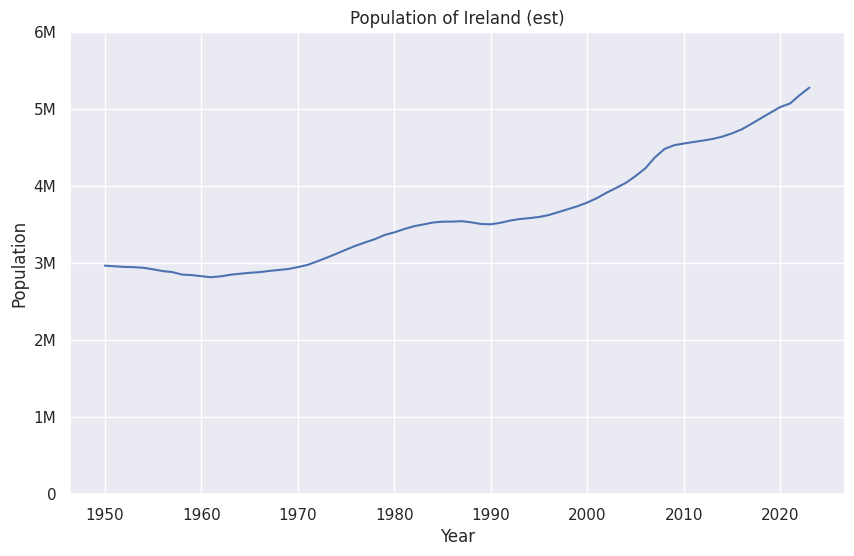

In [25]:
all_ages_df = both_sexes_df[both_sexes_df['age_group'] == 'All ages'].copy()
all_ages_df['value'] = all_ages_df['value']*1000

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.lineplot(all_ages_df, x='year', y='value')
p.set(title='Population of Ireland (est)', xlabel='Year', ylabel='Population', ylim=(0,None))
ylabs = ['{:,.0f}M'.format(x) if x > 0.1 else 0 for x in p.get_yticks()/1000000]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs);

We see that the overall population trend has been increasing, however we see periods of decline/stability in the 50s - early 70s, the late 80s - mid-90s, and the late 2000s - mid 2010s.

---
TODO: bring in migration data and births/deaths and compare net migration to this - are the growth periods / stable periods driven by migration or births?

---

We next look at the same trend but split by gender. We need a colour palette that has high contrast to differentiate between the two lines, which the seaborn default gives us. However, the chosen palette is also colourblind friendly, as it was retrieved from David Nichol's "Coloring for Colorblindness" tool (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40)

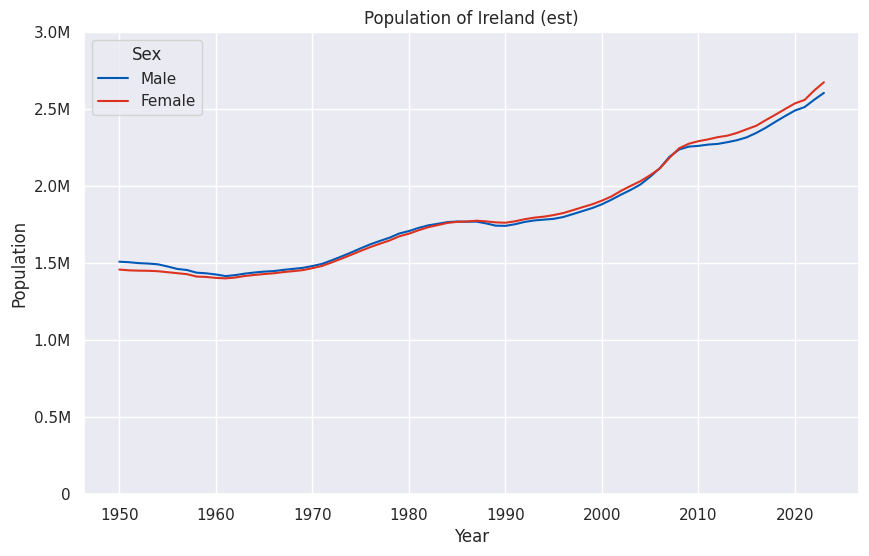

In [26]:
all_ages_gendered_df = sexes_df[sexes_df['age_group'] == 'All ages'].copy()
all_ages_gendered_df['value'] = all_ages_gendered_df['value']*1000

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.lineplot(all_ages_gendered_df, x='year', y='value', hue='sex', palette=['#005AB5', '#DC3220'])
p.set(title='Population of Ireland (est)', xlabel='Year', ylabel='Population', ylim=(0,None))
ylabs = ['{:,.1f}M'.format(x) if x > 0.1 else 0 for x in p.get_yticks()/1000000]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
p.legend(title='Sex');

We can see that for most of the time series the gender balance was roughly equal - however in the 1950s there were slightly more males than females, and since the late 2000s there appear to have been more females than males.

---
TODO: 

Compare to migration data - are the gender differences now driven by gender imbalances in emigration / migration

Look at total and gendered splits across age ranges

---

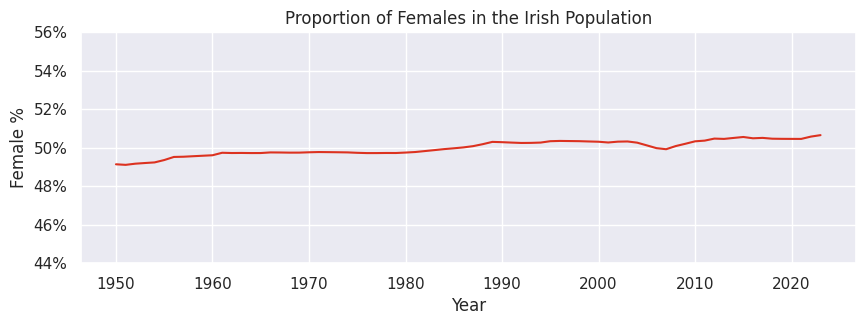

In [27]:
# all_ages_gendered_df['total'] = 
all_ages_gendered_total = all_ages_gendered_df.join(all_ages_gendered_df\
        .groupby('year')\
        .sum()\
        .rename(columns={'value': 'total'})['total'], on='year')

all_ages_gendered_total['prop'] =  (all_ages_gendered_total['value']/all_ages_gendered_total['total'])*100

fig, ax = plt.subplots(figsize=(10, 3)) 
p = sns.lineplot(all_ages_gendered_total[all_ages_gendered_total['sex']=='Female'], x='year', y='prop', hue='sex', palette=['#DC3220'])
p.set(title='Proportion of Females in the Irish Population', xlabel='Year', ylabel='Female %', ylim=(45,55))
ylabs = ['{:,.0f}%'.format(x) for x in p.get_yticks()]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
p.legend([],[], frameon=False);

Much like the sex variable, we have overlapping age bounds within out age_group variable, so were we to add up the population per year in this case, we would be double counting in multiple instances. We would like to use a covering of all ages that is comprised of non-overlapping age ranges, and in this case we have multiple choices for what this might be. i

We could choose the one which gives us the highest level of granularity / the most levels within our age factor (i.e. - choosing under 1 year and 1-4 years, rather than 0-4 years), however we can also choose to have each of the age ranges (except 85+) be equal width. In either case we will make use of our 1-4 year or 0-4 year age range, which we cleaned earlier.

In [28]:
both_sexes_df['age_group'].unique()

array(['Under 1 year', '0 - 4 years', '0 - 14 years', '1 - 4 years',
       '5 - 9 years', '10 - 14 years', '15 - 19 years', '15 - 24 years',
       '15 years and over', '20 - 24 years', '25 - 29 years',
       '25 - 44 years', '30 - 34 years', '35 - 39 years', '40 - 44 years',
       '45 - 49 years', '45 - 64 years', '50 - 54 years', '55 - 59 years',
       '60 - 64 years', '65 - 69 years', '65 years and over',
       '70 - 74 years', '75 - 79 years', '80 - 84 years',
       '85 years and over', 'All ages'], dtype=object)

Each of the variables we want to use contains a moving 5 year window in its name. We can refer to this by splitting the range function into two iterators using itertools.tee(), advancing the second one by 1 position using next(), then moving through the lower and upper bounds of the age ranges pairwise using zip() - formatting our names as we go within a list comprehension.

In [29]:
age_lower, age_upper = itertools.tee(range(0,86,5))
next(age_upper)

covering_age_levels = [f'{low} - {high - 1} years' for low, high in zip(age_lower, age_upper)] + ['85 years and over']
covering_age_levels

['0 - 4 years',
 '5 - 9 years',
 '10 - 14 years',
 '15 - 19 years',
 '20 - 24 years',
 '25 - 29 years',
 '30 - 34 years',
 '35 - 39 years',
 '40 - 44 years',
 '45 - 49 years',
 '50 - 54 years',
 '55 - 59 years',
 '60 - 64 years',
 '65 - 69 years',
 '70 - 74 years',
 '75 - 79 years',
 '80 - 84 years',
 '85 years and over']

We can visualise this as a line chart as before, splitting on age range. However, our colour palette from before does not have enough levels to represent this. We instead choose a sequential colour palette which darkens in hue across the age ranges. The age levels are ordered, so it makes sense to use a sequential palette as opposed to a categorical one.

One observation that we can note from this type of visualization however, is that we can see the same patterns occurring on each line lagged by 5 years, as we have the same population ageing and continuously falling into the next category across time, with the slopes lessening towards the higher age categories indicative of mortality at higher ages.

We can also see the youngest age categories going from being the most populous in the 1950s, to being overtaken by working ages in the 2000s. This is indicative of a shift in demographic makeup, although it is unclear from this chart alone whether that is driven by birth rates or migration. 

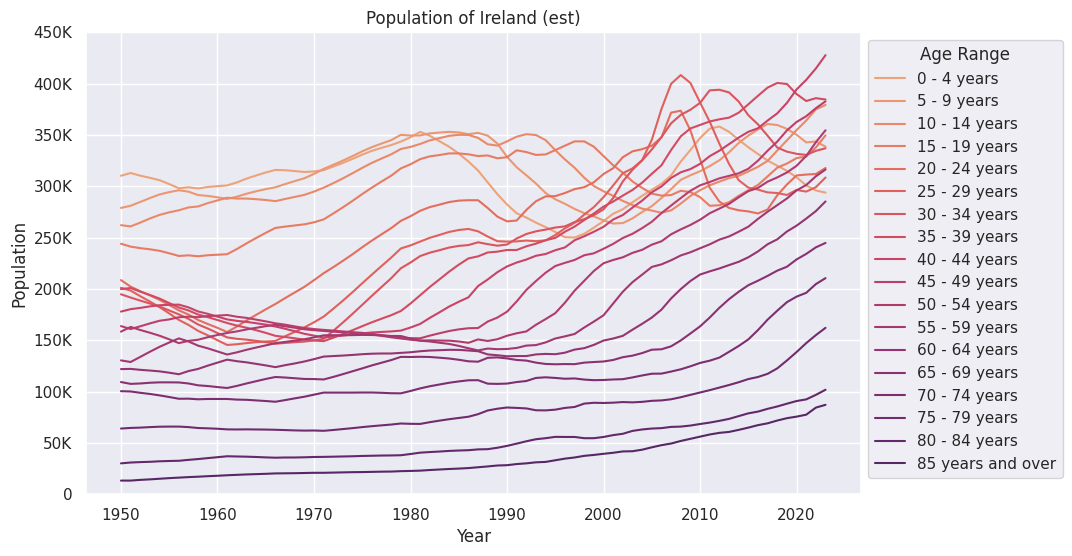

In [30]:
both_sexes_age_df =  both_sexes_df[both_sexes_df['age_group'].isin(covering_age_levels)]

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.lineplot(both_sexes_age_df, x='year', y='value', hue='age_group', palette=sns.color_palette("flare", n_colors=len(covering_age_levels)))
p.set(title='Population of Ireland (est)', xlabel='Year', ylabel='Population', ylim=(0,None))
ylabs = ['{:,.0f}K'.format(x) if x > 0.1 else 0 for x in p.get_yticks()]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
p.legend(title='Age Range')
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

We would like to look at population age composition separated by year, however 70+ charts would be excessive, so we will bucket the years together into a range, similar to the age_range variable. Grouping by decade would be the obvious choice, however we can see from the above chart that some of the rapid changes in demographic occur over a shorter period than that, so we will choose buckets of 5 years. 

As we will be looking at multiple individual charts, we can also reintroduce gender at this point without creating too much visual clutter.

In [31]:
sexes_age_df =  sexes_df[sexes_df['age_group'].isin(covering_age_levels)].copy()

# pull the years back to the half decade below them with floor division - https://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
sexes_age_df['half_decade'] = (sexes_age_df.year//5)*5 
sexes_age_df['half_decade'] = sexes_age_df['half_decade'].apply(lambda x: f"{x} - {x+4}")

# sexes_age_df['decade'] = (sexes_age_df.year//10)*10 
# sexes_age_df['decade'] = sexes_age_df['decade'].apply(lambda x: f"{x}s")

half_decade_df = sexes_age_df.groupby(['half_decade', 'age_group', 'sex'])[['value']].mean().reset_index()                                                               
half_decade_df['value'] = half_decade_df['value']*[-1 if x == 'Female' else 1 for x in half_decade_df['sex']]
half_decade_df.head()

,half_decade,age_group,sex,value
0,1950 - 1954,0 - 4 years,Female,-151.18
1,1950 - 1954,0 - 4 years,Male,158.30
2,1950 - 1954,10 - 14 years,Female,-130.48
3,1950 - 1954,10 - 14 years,Male,135.18
4,1950 - 1954,15 - 19 years,Female,-114.98


We can visualise the changing population makeup across genders and ages using multiple population pyramids (or age structure diagrams), which are a type of paired bar plots typically used for this purpose (Wilson 2016).

This shows that the population in Ireland has shifted from having a relatively wide base - indicative of many births and young people - to having a wide middle and comparatively narrower base, which may indicate a lower birth rate. A particularly notable change in the width of the middle ages can be seen in 2000-2010 - which we expected to see given the above line chart.

This could also explain the higher percentage of females in recent years we saw previously, as women have a longer life expectancy than men (Gryclewska, 2016), therefore an aging population would naturally be comprised of more women - the gender difference in the older cohorts can be seen clearly in the plots from 2000 onwards.

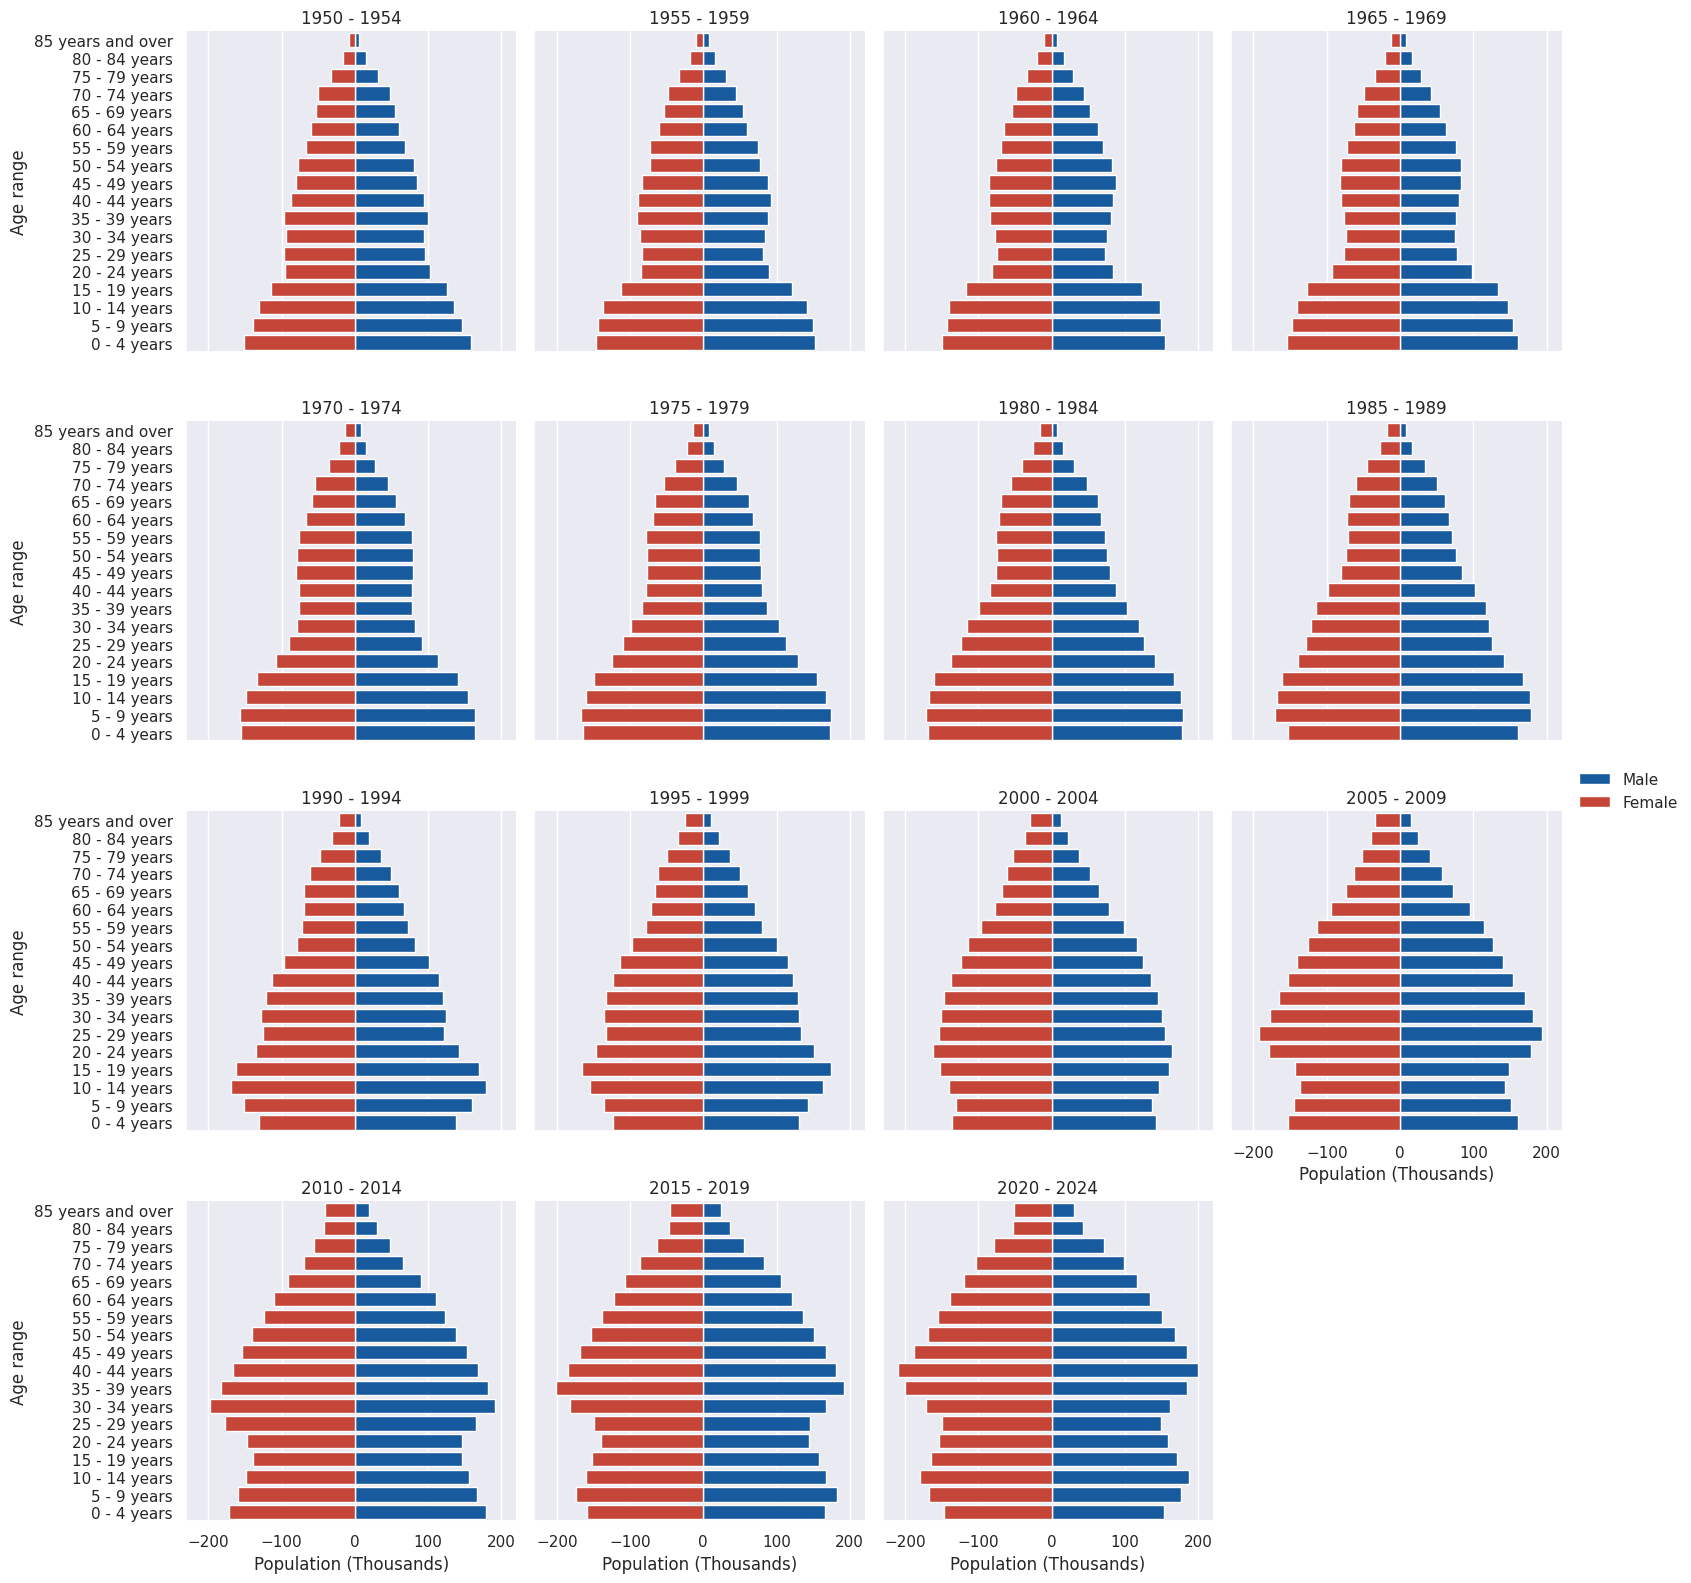

In [32]:
p = sns.FacetGrid(half_decade_df, col='half_decade', col_wrap=4, margin_titles=True, height=4)
p.map_dataframe(sns.barplot, # map_dataframe exposes column names from the FacetGrid object's data for mapping to chart aesthetics
    x='value', 
    y='age_group', 
    hue='sex', 
    hue_order=['Male', 'Female'],
    palette=['#005AB5', '#DC3220'], 
    orient='horizontal', 
    order=covering_age_levels[::-1], # reverse the age levels so youngest is at the bottom
    dodge=False) # Have the male and female bars be on the same Y level
p.add_legend()
p.set_titles(template="{col_name}")
# TODO: I'm unsure how to change x tick labels within a FacetGrid - Ideally I'd have positive values displayed along negative X axis and add a K suffix
p.set_xlabels(label='Population (Thousands)')
p.set_ylabels(label='Age range');


# Migration Data Exploration

We would like to try and gain some understanding of some of the population changes seen above, and bringing in migration data will help us to do this. We can start to ask questions like;
- Are gender imbalances in the population due to the gender imbalances within the  immigrant/emigrant populations, or is it down to age and death rates as posited above?
- How much is immigration contributing to the population growth seen above?

On loading the migration data we see that again, we have missing values in the value column. These primarily appear to effect the net migration and All ages datapoints more often, so we can see if they can be repaired using the filled values as above.

In [33]:
migration_df = read_csv_and_fix_names('data/migration_1987_2023.csv')
print(migration_df.dtypes, '\n')
print(f'Row count: {len(migration_df)}', '\n')
migration_df.head(n=20)

statistic_label            object
year                        int64
age_group                  object
sex                        object
inward_or_outward_flow     object
unit                       object
value                     float64
dtype: object 

Row count: 1998 



,statistic_label,year,age_group,sex,inward_or_outward_flow,unit,value
0,Estimated Migration (Persons in April),1987,All ages,Both sexes,Net migration,Thousand,-23.0
1,Estimated Migration (Persons in April),1987,All ages,Both sexes,Emigrants: All destinations,Thousand,40.2
2,Estimated Migration (Persons in April),1987,All ages,Both sexes,Immigrants: All origins,Thousand,17.2
3,Estimated Migration (Persons in April),1987,All ages,Male,Net migration,Thousand,NaN
4,Estimated Migration (Persons in April),1987,All ages,Male,Emigrants: All destinations,Thousand,NaN
5,Estimated Migration (Persons in April),1987,All ages,Male,Immigrants: All origins,Thousand,NaN
6,Estimated Migration (Persons in April),1987,All ages,Female,Net migration,Thousand,NaN
7,Estimated Migration (Persons in April),1987,All ages,Female,Emigrants: All destinations,Thousand,NaN
8,Estimated Migration (Persons in April),1987,All ages,Female,Immigrants: All origins,Thousand,NaN
9,Estimated Migration (Persons in April),1987,0 - 14 years,Both sexes,Net migration,Thousand,NaN


In [34]:
# Checking the levels of age_group to see how we can join back to population estimates table
migration_df['age_group'].unique()

array(['All ages', '0 - 14 years', '15 - 24 years', '25 - 44 years',
       '45 - 64 years', '65 years and over'], dtype=object)

In [35]:
## Null values across categorical variables
print(migration_df.loc[pd.isna(migration_df.value)]['age_group'].value_counts(), '\n')
print(migration_df.loc[pd.isna(migration_df.value)]['inward_or_outward_flow'].value_counts())

age_group
All ages             90
0 - 14 years         45
15 - 24 years        45
25 - 44 years        45
45 - 64 years        45
65 years and over    45
Name: count, dtype: int64 

inward_or_outward_flow
Net migration                  255
Emigrants: All destinations     30
Immigrants: All origins         30
Name: count, dtype: int64


In [36]:
pivoted_migration_df = migration_df.pivot(columns=['inward_or_outward_flow'], index=['year', 'sex', 'age_group'], values='value')
pivoted_migration_df.head(n=20)

inward_or_outward_flow             Emigrants: All destinations  \
year sex        age_group                                        
1987 Both sexes 0 - 14 years                               2.8   
                15 - 24 years                             24.0   
                25 - 44 years                             11.8   
                45 - 64 years                              1.7   
                65 years and over                          0.0   
                All ages                                  40.2   
     Female     0 - 14 years                               1.3   
                15 - 24 years                             11.7   
                25 - 44 years                              4.9   
                45 - 64 years                              0.7   
                65 years and over                          0.0   
                All ages                                   NaN   
     Male       0 - 14 years                               1.4   
                15 - 24 years                             12.3   
                25 - 44 years                              6.9   
                45 - 64 years                              1.0   
                65 years and over                          0.0   
                All ages                                   NaN   
1988 Both sexes 0 - 14 years                               8.3   
                15 - 24 years                             31.2   

inward_or_outward_flow             Immigrants: All origins  Net migration  
year sex        age_group                                                  
1987 Both sexes 0 - 14 years                           3.1            NaN  
                15 - 24 years                          5.1            NaN  
                25 - 44 years                          6.1            NaN  
                45 - 64 years                          1.8            NaN  
                65 years and over                      1.1            NaN  
                All ages                              17.2          -23.0  
     Female     0 - 14 years                           1.8            NaN  
                15 - 24 years                          3.2            NaN  
                25 - 44 years                          2.7            NaN  
                45 - 64 years                          0.8            NaN  
                65 years and over                      0.6            NaN  
                All ages                               NaN            NaN  
     Male       0 - 14 years                           1.3            NaN  
                15 - 24 years                          1.9            NaN  
                25 - 44 years                          3.4            NaN  
                45 - 64 years                          1.0            NaN  
                65 years and over                      0.5            NaN  
                All ages                               NaN            NaN  
1988 Both sexes 0 - 14 years                           3.0            NaN  
                15 - 24 years                          5.4            NaN

In [37]:
pivoted_migration_df.tail(n=20)

inward_or_outward_flow             Emigrants: All destinations  \
year sex        age_group                                        
2022 Male       65 years and over                          1.1   
                All ages                                  29.6   
2023 Both sexes 0 - 14 years                               5.5   
                15 - 24 years                             19.9   
                25 - 44 years                             32.3   
                45 - 64 years                              5.3   
                65 years and over                          1.0   
                All ages                                  64.0   
     Female     0 - 14 years                               2.6   
                15 - 24 years                             12.3   
                25 - 44 years                             15.2   
                45 - 64 years                              2.2   
                65 years and over                          0.6   
                All ages                                  32.9   
     Male       0 - 14 years                               2.9   
                15 - 24 years                              7.5   
                25 - 44 years                             17.2   
                45 - 64 years                              3.0   
                65 years and over                          0.4   
                All ages                                  31.0   

inward_or_outward_flow             Immigrants: All origins  Net migration  
year sex        age_group                                                  
2022 Male       65 years and over                      1.7            0.5  
                All ages                              49.2           19.6  
2023 Both sexes 0 - 14 years                          21.8           16.3  
                15 - 24 years                         23.8            3.9  
                25 - 44 years                         75.1           42.7  
                45 - 64 years                         16.9           11.7  
                65 years and over                      4.0            3.0  
                All ages                             141.6           77.7  
     Female     0 - 14 years                          10.8            8.2  
                15 - 24 years                         13.7            1.4  
                25 - 44 years                         38.2           23.1  
                45 - 64 years                         10.3            8.1  
                65 years and over                      2.5            1.8  
                All ages                              75.5           42.6  
     Male       0 - 14 years                          11.1            8.2  
                15 - 24 years                         10.0            2.5  
                25 - 44 years                         36.8           19.6  
                45 - 64 years                          6.6            3.6  
                65 years and over                      1.5            1.1  
                All ages                              66.1           35.1

As suspected, the net migration values are not missing in more recent data. It's possible that this was not originally calculated when records began. We can easily fill in the NaNs by subtracting emigrants from immigrants with the data in this pivoted form, however we will first need to address the other missing values, or else we would be left with missing values corresponding to All ages.

We will first pivot with the age group across the columns, repair All ages by adding the figures for the other ages together, then repivot with inward_or_outward_flow across the columns, then finally repair Net Migration.

In [38]:
pivoted_migration_df = migration_df.pivot(columns=['age_group'], index=['year', 'sex', 'inward_or_outward_flow'], values='value')
pivoted_migration_df.head()

age_group                                    0 - 14 years  15 - 24 years  \
year sex        inward_or_outward_flow                                     
1987 Both sexes Emigrants: All destinations           2.8           24.0   
                Immigrants: All origins               3.1            5.1   
                Net migration                         NaN            NaN   
     Female     Emigrants: All destinations           1.3           11.7   
                Immigrants: All origins               1.8            3.2   

age_group                                    25 - 44 years  45 - 64 years  \
year sex        inward_or_outward_flow                                      
1987 Both sexes Emigrants: All destinations           11.8            1.7   
                Immigrants: All origins                6.1            1.8   
                Net migration                          NaN            NaN   
     Female     Emigrants: All destinations            4.9            0.7   
                Immigrants: All origins                2.7            0.8   

age_group                                    65 years and over  All ages  
year sex        inward_or_outward_flow                                    
1987 Both sexes Emigrants: All destinations                0.0      40.2  
                Immigrants: All origins                    1.1      17.2  
                Net migration                              NaN     -23.0  
     Female     Emigrants: All destinations                0.0       NaN  
                Immigrants: All origins                    0.6       NaN

In [39]:
# Confirm that the missing values in the non-age group variables are only on the net migration rows
pd.isna(pivoted_migration_df.loc[pivoted_migration_df.index.get_level_values('inward_or_outward_flow') != 'Net migration']).sum()

age_group
0 - 14 years          0
15 - 24 years         0
25 - 44 years         0
45 - 64 years         0
65 years and over     0
All ages             60
dtype: int64

In [40]:
age_columns = [x for x in pivoted_migration_df.columns if x != 'All ages']
pivoted_migration_df['All ages'] = pivoted_migration_df.loc[:, age_columns].sum(axis=1)
pivoted_migration_df.head()

age_group                                    0 - 14 years  15 - 24 years  \
year sex        inward_or_outward_flow                                     
1987 Both sexes Emigrants: All destinations           2.8           24.0   
                Immigrants: All origins               3.1            5.1   
                Net migration                         NaN            NaN   
     Female     Emigrants: All destinations           1.3           11.7   
                Immigrants: All origins               1.8            3.2   

age_group                                    25 - 44 years  45 - 64 years  \
year sex        inward_or_outward_flow                                      
1987 Both sexes Emigrants: All destinations           11.8            1.7   
                Immigrants: All origins                6.1            1.8   
                Net migration                          NaN            NaN   
     Female     Emigrants: All destinations            4.9            0.7   
                Immigrants: All origins                2.7            0.8   

age_group                                    65 years and over  All ages  
year sex        inward_or_outward_flow                                    
1987 Both sexes Emigrants: All destinations                0.0      40.3  
                Immigrants: All origins                    1.1      17.2  
                Net migration                              NaN       0.0  
     Female     Emigrants: All destinations                0.0      18.6  
                Immigrants: All origins                    0.6       9.1

In [41]:
# the sum added the nans together to 0, which we don't want 
pivoted_migration_df['All ages'] = pivoted_migration_df.apply(lambda row: np.nan if any(pd.isna(row)) else row['All ages'] , axis=1)
pivoted_migration_df.head()

age_group                                    0 - 14 years  15 - 24 years  \
year sex        inward_or_outward_flow                                     
1987 Both sexes Emigrants: All destinations           2.8           24.0   
                Immigrants: All origins               3.1            5.1   
                Net migration                         NaN            NaN   
     Female     Emigrants: All destinations           1.3           11.7   
                Immigrants: All origins               1.8            3.2   

age_group                                    25 - 44 years  45 - 64 years  \
year sex        inward_or_outward_flow                                      
1987 Both sexes Emigrants: All destinations           11.8            1.7   
                Immigrants: All origins                6.1            1.8   
                Net migration                          NaN            NaN   
     Female     Emigrants: All destinations            4.9            0.7   
                Immigrants: All origins                2.7            0.8   

age_group                                    65 years and over  All ages  
year sex        inward_or_outward_flow                                    
1987 Both sexes Emigrants: All destinations                0.0      40.3  
                Immigrants: All origins                    1.1      17.2  
                Net migration                              NaN       NaN  
     Female     Emigrants: All destinations                0.0      18.6  
                Immigrants: All origins                    0.6       9.1

In [42]:
molten_migration_df = pivoted_migration_df.reset_index().melt(id_vars=['year', 'sex', 'inward_or_outward_flow'])
molten_migration_df.head()

,year,sex,inward_or_outward_flow,age_group,value
0,1987,Both sexes,Emigrants: All destinations,0 - 14 years,2.8
1,1987,Both sexes,Immigrants: All origins,0 - 14 years,3.1
2,1987,Both sexes,Net migration,0 - 14 years,NaN
3,1987,Female,Emigrants: All destinations,0 - 14 years,1.3
4,1987,Female,Immigrants: All origins,0 - 14 years,1.8


In [43]:
repivoted_migration_df = molten_migration_df.pivot(columns=['inward_or_outward_flow'], index=['year', 'sex', 'age_group'], values='value')
repivoted_migration_df['Net migration'] = repivoted_migration_df['Immigrants: All origins'] - repivoted_migration_df['Emigrants: All destinations'] 
repivoted_migration_df.head(n=10) 

inward_or_outward_flow             Emigrants: All destinations  \
year sex        age_group                                        
1987 Both sexes 0 - 14 years                               2.8   
                15 - 24 years                             24.0   
                25 - 44 years                             11.8   
                45 - 64 years                              1.7   
                65 years and over                          0.0   
                All ages                                  40.3   
     Female     0 - 14 years                               1.3   
                15 - 24 years                             11.7   
                25 - 44 years                              4.9   
                45 - 64 years                              0.7   

inward_or_outward_flow             Immigrants: All origins  Net migration  
year sex        age_group                                                  
1987 Both sexes 0 - 14 years                           3.1            0.3  
                15 - 24 years                          5.1          -18.9  
                25 - 44 years                          6.1           -5.7  
                45 - 64 years                          1.8            0.1  
                65 years and over                      1.1            1.1  
                All ages                              17.2          -23.1  
     Female     0 - 14 years                           1.8            0.5  
                15 - 24 years                          3.2           -8.5  
                25 - 44 years                          2.7           -2.2  
                45 - 64 years                          0.8            0.1

In [44]:
cleaned_migration_df = repivoted_migration_df.reset_index().melt(id_vars=['year', 'sex', 'age_group'])
print(pd.isna(cleaned_migration_df).sum(), '\n')
print(f'Row count: {len(cleaned_migration_df)}', '\n')
cleaned_migration_df.head(n=10)

year                      0
sex                       0
age_group                 0
inward_or_outward_flow    0
value                     0
dtype: int64 

Row count: 1998 



,year,sex,age_group,inward_or_outward_flow,value
0,1987,Both sexes,0 - 14 years,Emigrants: All destinations,2.8
1,1987,Both sexes,15 - 24 years,Emigrants: All destinations,24.0
2,1987,Both sexes,25 - 44 years,Emigrants: All destinations,11.8
3,1987,Both sexes,45 - 64 years,Emigrants: All destinations,1.7
4,1987,Both sexes,65 years and over,Emigrants: All destinations,0.0
5,1987,Both sexes,All ages,Emigrants: All destinations,40.3
6,1987,Female,0 - 14 years,Emigrants: All destinations,1.3
7,1987,Female,15 - 24 years,Emigrants: All destinations,11.7
8,1987,Female,25 - 44 years,Emigrants: All destinations,4.9
9,1987,Female,45 - 64 years,Emigrants: All destinations,0.7


We now have a cleaned migration dataset in the same format we started with, with the missing values repaired. In order to plot it however, we will want to work with the pivoted form. We can display emigration and immigration as bars, with an accompanying line denoting net migration. Although emigration results in a reduction in the population and immigration results in an increase in the population, I have elected not to use typical increasing / decreasing colour choices (blue for increasing, red for decreasing, etc.) as these may also be interpreted as ascribing goodness or badness to either phenomenon, which I want to avoid.

In [45]:
both_sexes_all_ages_migration_df = cleaned_migration_df[
    (cleaned_migration_df['age_group'] == 'All ages') & 
    (cleaned_migration_df['sex'] == 'Both sexes')
    ].pivot(columns=['inward_or_outward_flow'], index=['year', 'sex', 'age_group'], values='value').reset_index().copy()
both_sexes_all_ages_migration_df['Emigrants: All destinations'] =  both_sexes_all_ages_migration_df['Emigrants: All destinations']*-1
both_sexes_all_ages_migration_df.head()

inward_or_outward_flow,year,sex,age_group,Emigrants: All destinations,Immigrants: All origins,Net migration
0,1987,Both sexes,All ages,-40.3,17.2,-23.1
1,1988,Both sexes,All ages,-61.0,19.2,-41.8
2,1989,Both sexes,All ages,-70.5,26.7,-43.8
3,1990,Both sexes,All ages,-56.3,33.4,-22.9
4,1991,Both sexes,All ages,-35.4,33.3,-2.1


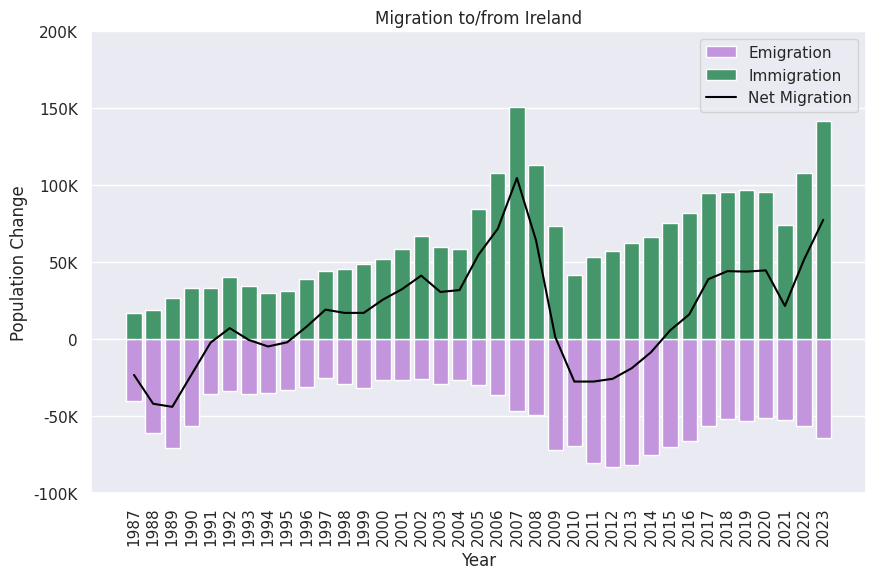

In [46]:
plt.figure(figsize=(10, 6)) 
numrows = len(both_sexes_all_ages_migration_df)
p = sns.barplot(both_sexes_all_ages_migration_df , x='year', y='Emigrants: All destinations', hue=['Emigration']*numrows, palette=['#C589E8'])
sns.barplot(both_sexes_all_ages_migration_df , x='year', y='Immigrants: All origins', hue=['Immigration']*numrows, palette=['#37A56A'])
sns.lineplot(both_sexes_all_ages_migration_df , x=p.get_xticks(), y='Net migration', hue=["Net Migration"]*numrows, palette=['#000000'])
p.set(title='Migration to/from Ireland', xlabel="Year", ylabel="Population Change")
ylabs = ['{:,.0f}K'.format(x) if abs(x) > 0.1 else 0 for x in p.get_yticks()]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
plt.xticks(rotation=90);

Low immigration in 2021 - covid?

There was a period of net emigration after 2008 crash, it looks like pre and post 2008, our emigration figures can be thought of as coming from different distributions.

We can use a qqplot to check the emigration variable's distribution agains a theoretical normal distribution. Although, we would expect emigration to increase as the overall population increases, so in this case we can look at emigration as a percentage of total population to control for this. 


In [47]:
pop_migration_df = all_ages_df.rename(columns={'value': 'population'}).merge(both_sexes_all_ages_migration_df, on=['year', 'sex', 'age_group'])
pop_migration_df['emigration_pop_pct'] = (np.abs(pop_migration_df['Emigrants: All destinations'])*1000)/pop_migration_df['population']
pop_migration_df['immigration_pop_pct'] = (np.abs(pop_migration_df['Immigrants: All origins'])*1000)/pop_migration_df['population']
pop_migration_df['net_migration_pct'] = pop_migration_df['immigration_pop_pct'] - pop_migration_df['emigration_pop_pct']
pop_migration_df.head()

,statistic_label,year,age_group,sex,unit,population,Emigrants: All destinations,Immigrants: All origins,Net migration,emigration_pop_pct,immigration_pop_pct,net_migration_pct
0,Population Estimates (Persons in April),1987,All ages,Both sexes,Thousand,3546500.0,-40.3,17.2,-23.1,0.011363,0.004850,-0.006513
1,Population Estimates (Persons in April),1988,All ages,Both sexes,Thousand,3530700.0,-61.0,19.2,-41.8,0.017277,0.005438,-0.011839
2,Population Estimates (Persons in April),1989,All ages,Both sexes,Thousand,3509500.0,-70.5,26.7,-43.8,0.020088,0.007608,-0.012480
3,Population Estimates (Persons in April),1990,All ages,Both sexes,Thousand,3505800.0,-56.3,33.4,-22.9,0.016059,0.009527,-0.006532
4,Population Estimates (Persons in April),1991,All ages,Both sexes,Thousand,3525700.0,-35.4,33.3,-2.1,0.010041,0.009445,-0.000596


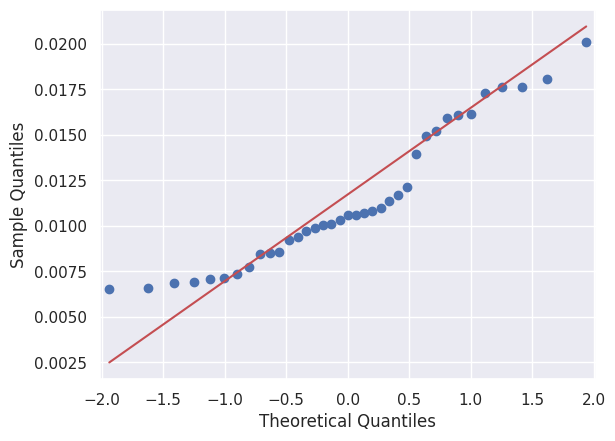

In [48]:
sm.qqplot(pop_migration_df['emigration_pop_pct'], line='q');

This is a poor fit - implying a nonnormal distribution for the overall series.

The inflection point at 0.5 indicates bimodality - something we can again see with a histogram. So we should look at separate qq plots pre and post 2008 to see if these partitoned series are distributed normally.

<Axes: xlabel='emigration_pop_pct', ylabel='Density'>

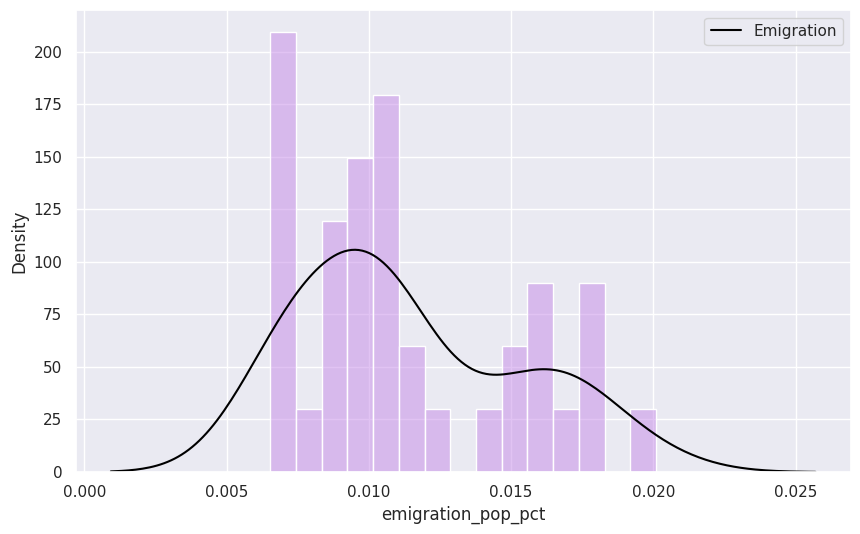

In [49]:
# todo - get these on the same scale - looks like a mixture of normal distributions
plt.figure(figsize=(10, 6)) 
numrows = len(pop_migration_df)
p = sns.histplot(pop_migration_df , x='emigration_pop_pct', hue=['Emigration']*numrows, palette=['#C589E8'], bins=15, stat='density')
sns.kdeplot(pop_migration_df , x='emigration_pop_pct', hue=['Emigration']*numrows, palette=['#000000'])
# p.set(title='Migration to/from Ireland', xlabel="Year", ylabel="Population Change")
# ylabs = ['{:,.0f}K'.format(x) if abs(x) > 0.1 else 0 for x in p.get_yticks()]
# p.set_yticks(p.get_yticks())
# p.set_yticklabels(ylabs)
# plt.xticks(rotation=90);

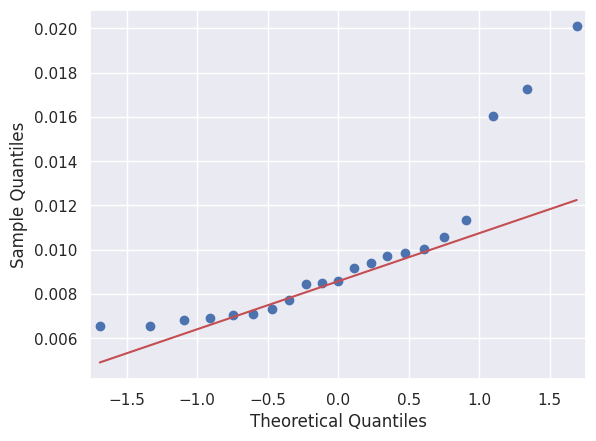

In [50]:
sm.qqplot(pop_migration_df.loc[pop_migration_df['year'] < 2008, 'emigration_pop_pct'], line='q');

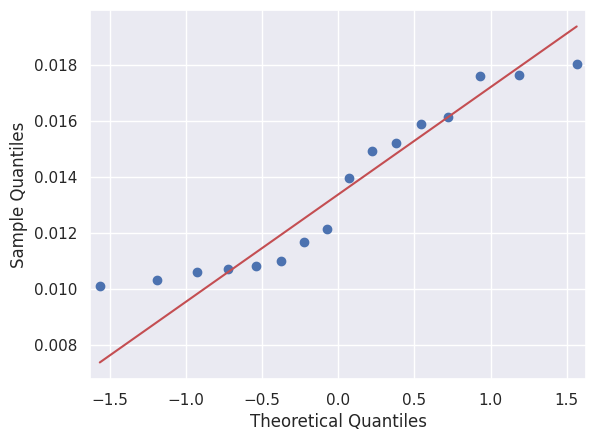

In [51]:
sm.qqplot(pop_migration_df.loc[pop_migration_df['year'] >= 2008, 'emigration_pop_pct'], line='q');

Neither of these are convincing fits, so this temporal partition does not cleanly split our data into two normally distributed subsets, and our emigration variable is not drawn from a Gaussian mixture delineated by 2008. 

## References
- Gryclewska, B., 2016. Why women live longer than men? Review of biological and non-biological factors. Przeglad lekarski 73, 392–394.
- Mckinney, W., 2010. Data structures for statistical computing in python. Proceedings of the 9th Python in Science Conference.
- Moritz, S., Sardá, A., Bartz-Beielstein, T., Zaefferer, M., Stork, J., 2015. Comparison of different Methods for Univariate Time Series Imputation in R.
- Wickham, H., 2014. Tidy Data. J. Stat. Soft. 59. https://doi.org/10.18637/jss.v059.i10
- Wilson, T., 2016. Visualising the demographic factors which shape population age structure. Demographic Research 35, 867–890.
- Yee, J.L., Niemeier, D.A., 1996. Advantages and disadvantages : longitudinal vs. repeated cross-section surveys.
- Nichol, D., Coloring for Colorblindness. https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40
